In [1]:
from pathlib import Path
import json
import pandas as pd
import re
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

# Does The Hot-Hands Effect Exist in NBA Basketball?

In basketball, the "hot hands effect" is a supposed phenomenon in which a person who makes several successful baskets in a row experiences a greater probability of scoring in further attempts.  For example, a player who has "made" three sucessful baskets in a row is considered to have a higher probability of making a 4th basket than if they had just missed a shot. In this assignment, we'll use 0 to represent a missed basket and 1 to represent a made basket. Restating the hot hands effect in these terms, under the hot hands theory, a player whose last three shots were `'111'` (three consecutive makes) has a higher chance of making a fourth basket than if their last three shots were `'110'`.  The failed third shot "resets" their hot hands.

The notion of a hot hand is often considered to be a cognitive fallacy, a tendency for our brains to ascribe more meaning to a random sequence of shots than it rightly should.  


## The Data

Shot records for the Golden State Warriors (our local NBA basketball team) from the 2016-2017 season are given to you in the `data_dir` path.  The files are stored in `json` format and are named '{match_date}0{team}.json'.  `match_date` is the date of the game and `team` is either 'GSW' or the abbreviation for the opposing team.  The structure of the data is simple: each file holds shot records for a single game in key/value pairs.  The keys are player names and the values are ordered arrays of shot attempts.  A `1` represents a "make" (successful attempt) and a `0` is a "miss" (failed attempt).  Although this will perhaps overly simplify the analysis, for this assignment, we will not differentiate between 2-point attempts (2FGA), 3-point attempts (3FGA), and free-throws (FT).

# Loading and Cleaning Data 

##### Building Dataframe from JSON Game File Data

In [2]:
pd.read_csv('single_file_shot_data_example.csv')

,player,shots,game
0,A. Iguodala,001,201610250GSW
1,A. Varejao,01,201610250GSW
2,D. Bertans,11,201610250GSW
3,D. Dedmon,0010,201610250GSW
4,D. Green,0010011110100111,201610250GSW
5,D. Lee,110101,201610250GSW
6,D. West,10,201610250GSW
7,I. Clark,0011001000,201610250GSW
8,J. McGee,100,201610250GSW
9,J. Simmons,11111101001000001,201610250GSW


In [3]:
def game_json_to_game_df(json_filename):
    with open(json_filename) as f:
        data = json.load(f)
    gameData = pd.DataFrame()
    gameData['player'] = data.keys()
    shots = []
    for i in data.values():
        made = ""
        for j in i:
            made+=(str(j))
        shots.append(made)
    gameData['shots'] = shots
    gameData['game'] = [str(json_filename)[10:22] for i in np.arange(len(data))]
    return gameData

In [4]:
datafile_path = Path('data/2017/201610250GSW.json')
student_output_201610250GSW = game_json_to_game_df(datafile_path)
student_output_201610250GSW

,player,shots,game
0,A. Iguodala,001,201610250GSW
1,A. Varejao,01,201610250GSW
2,D. Bertans,11,201610250GSW
3,D. Dedmon,0010,201610250GSW
4,D. Green,0010011110100111,201610250GSW
5,D. Lee,110101,201610250GSW
6,D. West,10,201610250GSW
7,I. Clark,0011001000,201610250GSW
8,J. McGee,100,201610250GSW
9,J. Simmons,11111101001000001,201610250GSW


Reading in all 99 `json` files and combine them into a single data frame called `unindexed_shot_data`

In [5]:
pd.read_csv('every_file_shot_data_first_25_rows.csv')

,player,shots,game
0,A. Iguodala,001,201610250GSW
1,A. Varejao,01,201610250GSW
2,D. Bertans,11,201610250GSW
3,D. Dedmon,0010,201610250GSW
4,D. Green,0010011110100111,201610250GSW
5,D. Lee,110101,201610250GSW
6,D. West,10,201610250GSW
7,I. Clark,0011001000,201610250GSW
8,J. McGee,100,201610250GSW
9,J. Simmons,11111101001000001,201610250GSW


In [6]:
data_dir = Path('data/2017')
games = list(data_dir.glob('**/*.json'))
unindexed_shot_data = pd.DataFrame()
for i in games:
     unindexed_shot_data = unindexed_shot_data.append(game_json_to_game_df(i), ignore_index = True)
unindexed_shot_data

,player,shots,game
0,A. Iguodala,1011,201702010GSW
1,A. Varejao,10,201702010GSW
2,B. Roberts,1111011,201702010GSW
3,C. Wood,111,201702010GSW
4,D. Green,1000011000,201702010GSW
5,D. Jones,111,201702010GSW
6,F. Kaminsky,001101111011101111,201702010GSW
7,I. Clark,000010,201702010GSW
8,J. Lamb,0100010000110,201702010GSW
9,J. McAdoo,100,201702010GSW


In [7]:
shot_data = unindexed_shot_data.set_index(['game', 'player'])
shot_data.head(5)

shots
game         player                 
201702010GSW A. Iguodala        1011
             A. Varejao           10
             B. Roberts      1111011
             C. Wood             111
             D. Green     1000011000

# The Hypothesis

Our null hypothesis is that there is no hot hands effect, meaning that the probability of making shots do not change when a player makes several baskets in a row. In this null world, every permutation of a given shot sequence is equally likely. For example '00111' is just as likely as '10101', '10011', and '01101'. In a universe where hot hands exists, the first sequence would be more likely than the other three.

We've hidden some other strong assumptions (perhaps erroneously) about the shots in our model.  Here are some things we are not controlling for:

* Opposing defenders affect the difficulty of a shot
* Distance affects the difficulty of a shot
* Shot types vary in difficulty (3-pointers, 2-points, free-throws)
* Team mate behavior may create more favorable scoring conditions

# Understanding the Data

To better understand our data before analyzing it, we'll take a look at 1 game from the Golden State Warriors. Let's take a look at [Klay Thompson's shooting performance from Dec. 5, 2016 versus the Indiana Pacers](https://www.basketball-reference.com/play-index/shooting.fcgi?player_id=thompkl01&year_id=2017&opp_id=IND&game_location=H).  Klay scored 60 points in 29 minutes of playing time. For those of you unfamiliar with basketball, this is a crazy number of points to score while only being in a game for 30 minutes. In the [entire history of professional basketball](https://www.basketball-reference.com/play-index/pgl_finder.cgi?request=1&match=game&is_playoffs=N&age_min=0&age_max=99&pos_is_g=Y&pos_is_gf=Y&pos_is_f=Y&pos_is_fg=Y&pos_is_fc=Y&pos_is_c=Y&pos_is_cf=Y&c1stat=mp&c1comp=lt&c1val=30&order_by=pts), nobody has come close (note these records are spotty before 1983). 

During this game, Klay took a total of 44 shots, landing 10/11 1 point free-throws, 13/19 2 point shots, and 8/14 3 point shots. [At least one news story](https://www.usatoday.com/story/sports/nba/warriors/2016/12/06/klay-thompson-60-points-outburst-by-the-numbers-warriors-pacers/95030316/) specifically called him out as having a 'hot hand' during this game.

We'll start by looking at this game to make sure we understanding the structure of the data.



In [8]:
klay_example = shot_data.loc[('201612050GSW', 'K. Thompson'), 'shots']
klay_example

'11011110010111111001110111101110111101010101'

In [9]:
attempts_ex = len(klay_example)
makes_ex = 0
for i in klay_example:
    if i == '1':
        makes_ex +=1
accuracy_ex = makes_ex / attempts_ex

print(f"""
attempts:  {attempts_ex}
makes:     {makes_ex}
accuracy:  {round(accuracy_ex, 2)}
""")


attempts:  44
makes:     31
accuracy:  0.7



We might be interested in the number of runs of various lengths that Thompson makes over the course of the game.  A run of length k is defined as k consecutive successes in a row.  We will include overlapping runs in our counts.  For example, the shot record `'1111'` contains three runs of length 2: <span style="background-color:yellow"><b>11</b></span>11, 1<span style="background-color:yellow"><b>11</b></span>1, 11<span style="background-color:yellow"><b>11</b></span>).

#### How many runs of length 2 did Thompson make in the Dec. 5, 2016 game? 

In [10]:
run_length_2 = 0
for i in range(1,attempts_ex):
    if klay_example[i-1] == '1' and klay_example[i] == '1':
        run_length_2 +=1
print(f"""
Klay Thompson made {run_length_2} runs of length 2 in the game against the Indiana Pacers.
""")


Klay Thompson made 19 runs of length 2 in the game against the Indiana Pacers.



#### How many runs of length 3?

In [11]:
run_length_3 = 0

for i in range(2,attempts_ex):
    if klay_example[i-2] == '1' and klay_example[i-1] == '1' and klay_example[i] == '1':
        run_length_3 +=1
print(f"""
Klay Thompson made {run_length_3} runs of length 3 in the game against the Indiana Pacers.
""")


Klay Thompson made 12 runs of length 3 in the game against the Indiana Pacers.



Let's generalize the work we did above by writing a function `count_runs`. `count_runs` takes two arguments:

* `shot_sequences`: a pandas series of strings, each representing a sequence of shots for a player in a game
* `run_length`: integer, the run length to count

`count_runs` should return a pandas series, where the ith element is the number of occurrences of `run_length` in the ith sequence in `shot_sequences`.

In [12]:
def count_runs(shot_sequences, run_length):
    shot_sequences = pd.Series(shot_sequences)
    total_runs = []
    for shot in shot_sequences:
        num_runs = 0
        for length in np.arange(run_length - 1, len(shot)):
            mismatch = False
            for i in np.arange(run_length):
                if shot[length - i] != '1':
                    mismatch = True
            if mismatch == False:
                num_runs +=1
        total_runs.append(num_runs)
    return pd.Series(total_runs)               

# Data Transformation

I will use `count_runs` to transform the data as follows: for each player, count the number of times they have made a run of length $k$ where $k = 1, 2, 3, ..., 10$.  The column names will be `str(k)` and the index be the player names.

In [13]:
dummy = shot_data
for i in np.arange(1,11):
    dummy[str(i)] = count_runs(dummy['shots'], i).values
run_counts = dummy.groupby('player').agg(np.sum)

# Test Statistic 

Let's try a test-statistic that captures the essence of "hot-hands" by exploring a well-known approach proposed by [Amos Tversky](https://en.wikipedia.org/wiki/Amos_Tversky) and his collaborators.  The hot hand of Tversky is similar to the notion of being "on fire" in the old arcade game [NBA Jam](https://www.youtube.com/watch?v=ipzstdPtxNw).  In that game, if you make 3 shots in a row with a player, your player would be on fire (with flame sprites!).  While on fire (until a miss), the player has an inflated probability of making shots.

The statistic to capture this affect, called $T_{k, make}$, is easy to compute:
\begin{align*}
  T_{k, make}
  & = \hat{\mathbb{P}}(\text{Make next shot}\ \vert\ \text{Made last $k$ shots})\\
  & = \frac{\#\{\text{Streaks of $k+1$ makes in a row}\}}{\#\{\text{Streaks of $k$ makes in a row preceeding an attempt}\}}
\end{align*}
If $T_{k, make}$ is especially high, then we might say that our player is experiencing a hot hand.

A similar statistic can try to capture a cold hand reversal:
\begin{align*}
  T_{k, miss}
  & = \hat{\mathbb{P}}(\text{Make next shot}\ \vert\ \text{Missed last $k$ shots})\\
  & = \frac{\#\{\text{Streaks of $k$ misses followed by make}\}}{\#\{\text{Streaks of $k$ misses in a row preceeding an attempt}\}}
\end{align*}
Note: If the value of $T_{k, miss}$ is especially high, this doesn't mean the player is expected to miss a bunch of shots in a  row, instead we'd say that they tend to see reversals in their streaks.

I will start by writing a utility function `count_conditionally`, which takes a `pd.Series` of shot sequence strings, a **conditioning set**, and an **event**, and returns a series of the count of the the number of times that the event follows the conditioning set in each shot sequence string.

**Example Behavior 1:** 

If we call `count_conditionally(['111111', '01111100111'], '111', '0')`, we are counting the number of times that the event `0` follows `111` in each string. In this case, the function would return `pd.Series([0, 1])`.

**Example Behavior 2:** 

If we call  `count_conditionally(['111111', '01111100111'], '111', '1')`, we are counting the number of times that the event `1` follows `111` in each string. In this case, the function would return `pd.Series([3, 2])`. Note that events can overlap, e.g. `111111` has 3 occurrences of the event `1` that follow the condition `111`: <span style="background-color:yellow"><b>111</b></span><span style="background-color:#32CD32"><b>1</b></span>11, 1<span style="background-color:yellow"><b>111</b></span><span style="background-color:#32CD32"><b>1</b></span>1, 11<span style="background-color:yellow"><b>111</b></span><span style="background-color:#32CD32"><b>1</b></span>.

In [14]:
def count_conditionally(shot_sequences, conditioning_set, event='1'):
    """
    shot_sequences: pd.Series (string) of shot strings for a set of games or a single string
       to be coerced into a pd.Series
    conditioning_set: string or regex pattern representing the conditioning set
    event: string or regex pattern representing the event of interest
    
    return: pd.Series of the number of times event occured after the
       conditioning set in each game
    """
    total_runs = []
    mustMatch = conditioning_set[0]
    for shot in shot_sequences:
        num_runs = 0
        for length in np.arange(len(conditioning_set) - 1, len(shot)-1):
            mismatch = False
            seq = ''
            for i in np.arange(len(conditioning_set)):
                if shot[length - i] != mustMatch:
                    mismatch = True
            if mismatch == False:
                if shot[length+1] == event:
                    num_runs +=1
        total_runs.append(num_runs)
    return pd.Series(total_runs)


### Capturing Null Cases

The Tversky statistic is sometimes undefined (has no valid value).  In our analysis, we will be discarding sequences where $T_k$ is undefined. Especially, when 

* the occurence is an unrealized conditioning set (for example, '011' for T_2 make or '110' for T_2 miss)
* the occurence never occurs in the set (for example, '111' for T_3 miss or '000' for T_3 make).

In [15]:
def calc_tk_stat(games, k):
    """
    Computes the tversky statistic for hot hands
        
    games: pd.Series (string) shot data for a set of games
    k: int, conditioning set length; number of misses/hits to condition on
    """
    conditioning_set_one = ''.join(str(int(e)) for e in np.ones(k))
    conditioning_set_zero = ''.join(str(int(e)) for e in np.zeros(k))
    t_k_make = count_conditionally(games, conditioning_set_one,'1').astype(np.float)[0] / (count_conditionally(games, conditioning_set_one,'1').astype(np.float)[0] + count_conditionally(games, conditioning_set_one,'0').astype(np.float)[0])
    t_k_miss = count_conditionally(games, conditioning_set_zero, '1').astype(np.float)[0] / (count_conditionally(games, conditioning_set_zero, '1').astype(np.float)[0] + count_conditionally(games, conditioning_set_zero, '0').astype(np.float)[0])
    if np.isnan(t_k_make) or np.isnan(t_k_miss):
        return np.nan
    else:
        return t_k_make - t_k_miss

# Statistically Testing Null Hypothesis using Tversky Statistic 

Now we return to the question of whether or not Thompson has hot hands. Under the hypothesis that he does have hot hands, Klay Thompson has a higher chance of making shots when he has recently made shots. Under the null hypothesis, his chance of making a shot is independent of recent successes.

To help carry out the analysis at scale, I will write a function `calc_p_values` that can take a `pd.Series` of test statistics (one for each game) and compare it to a `pd.DataFrame` of simulated statistics.  In the `pd.DataFrame`, each row corresponds to the a game, so the shape will be (number of games, number of bootstrap replications).  I will assume `observed_statistics` does not contain any `NaNs`; however, `simulated_statistics` may have some.

**Example Behavior**

If our observed statistics are `pd.Series([0.5, 0.35, 0.4])` and our simulated statistics are a Dataframe with the values:

```
0.1, 0.3, 0.4, 0.6, 0.4, 0.6, 0.8, 0.9
0.3, NaN, 0.7, 0.1, 0.3, 0.1, 0.8, 0.6
0.3, 0.7, 0.1, 0.6, 0.7, NaN, NaN, 0.2
```

My function should return `pd.Series([4/8, 3/7, 3/6])`, e.g. the number of simulated statistics that matched or exceeded the observed statistic were 4 out of a possible 8.

In [16]:
klay_data = shot_data.loc[pd.IndexSlice[:, 'K. Thompson'], 'shots']
klay_data.head(5)

game          player     
201702010GSW  K. Thompson       0101110101111101100010
201703210DAL  K. Thompson              010111111100001
201612150GSW  K. Thompson           010101101111001110
201702280WAS  K. Thompson     111000000100011010010000
201702100MEM  K. Thompson    0110101100111001111110100
Name: shots, dtype: object

In [17]:
def calc_p_values(observed_statistics, simulated_statistics):
    """
    observed_statistics: pd.Series (float), test statistics for each game 
    simulated_statistics: pd.DataFrame, rows represent games, columns contain 
        test statistics simulated under the null hypothesis 
    
    return: pd.Series (float), p-values for every game between 0 and 1
    """
    p_vals = []
    for i in np.arange(len(observed_statistics)):
        comparingTo = observed_statistics[i]
        length = len(np.array([x for x in simulated_statistics.loc[i] if str(x) != 'nan']))
        obs = len(np.array([x for x in simulated_statistics.loc[i] if x >= comparingTo]))
        p_vals.append(obs / length)
    return pd.Series(p_vals)

# Bootstrap Testing

I will carry out bootstrap hypothesis tests for all 95 records in `klay_data` for conditioning sets of length $k=1,2,3$.  I will use 10000 bootstrap replicates to approximate the sampling distribution in each test. 

In [18]:
#calculate simulated statistic
simulated_stat = pd.Series()
obs_tv_stats = {}
num_discarded = {}
p_vals = {}
significant = {}

#creating simulated_stat matrix
for i in np.arange(len(klay_data)):
    simulated_stat.loc[i] = ([int(klay_data[i][j]) for j in np.random.randint(len(klay_data[i]), size=10000)])

for k_val in np.arange(1,4):
    obs_tv_stat = []
    p_val = []
    for game in klay_data:
        obs_tv_stat.append(calc_tk_stat(pd.Series(game), k_val))
    num_discarded[k_val] = len([i for i in obs_tv_stat if str(i)=='nan'])
    obs_tv_stat = [i for i in obs_tv_stat if str(i)!='nan']
    obs_tv_stats[k_val] = obs_tv_stat
    p_val = calc_p_values(obs_tv_stat, simulated_stat)
    p_vals[k_val] = p_val
    significant[k_val] = len([i for i in p_val if i<0.05])

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


# Results 

We modeled Klay Thompson's shot record for each game as sequences of 1s and 0s (1 representing a made basket and 0 representing a missed basket) with the following assumptions

* Every shot has an equal probability of making or missing (2 pointers, 3 pointers, free throws)


We realize that this ignores the following real-life issues

* In a game situation, certain shots are more likely to make than others. For example, shots that are open are more likely to make than shots that are heavily contested. Also, shots closer to the basket are more likely to make than shots from half court.

Our null hypothesis is that there is no hot hands effect (in other words, that T_k = 0). In terms of our model, this means that the probability of making shots do not change when a player makes several baskets in a row. 

To test our hypothesis, we used the Tversky statistic, which can be interpreted as the notion of being "on fire", where until a miss, the player has an inflated probability of making shots.  This can be written mathematically as:

$$T_k = T_{k, make} - T_{k, miss}$$
$$ \begin{align*}
  T_{k, make}
  & = \hat{\mathbb{P}}(\text{Make next shot}\ \vert\ \text{Made last $k$ shots})\\
  & = \frac{\#\{\text{Streaks of $k+1$ makes in a row}\}}{\#\{\text{Streaks of $k$ makes in a row preceeding an attempt}\}}
\end{align*} $$

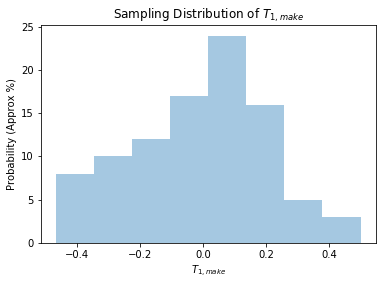

In [19]:
sns.distplot(obs_tv_stats[1],kde=False)
plt.title('Sampling Distribution of $T_{1, make}$')
plt.xlabel('$T_{1,make}$')
plt.ylabel('Probability (Approx %)');

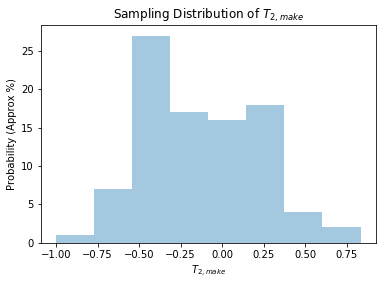

In [20]:
sns.distplot(obs_tv_stats[2],kde=False)
plt.title('Sampling Distribution of $T_{2, make}$')
plt.xlabel('$T_{2,make}$')
plt.ylabel('Probability (Approx %)');

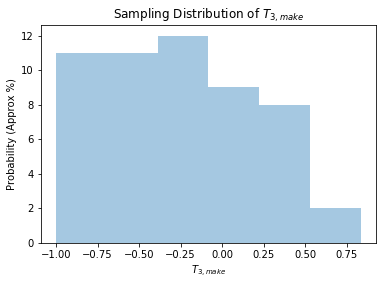

In [21]:
sns.distplot(obs_tv_stats[3],kde=False)
plt.title('Sampling Distribution of $T_{3, make}$')
plt.xlabel('$T_{3,make}$')
plt.ylabel('Probability (Approx %)');

By looking at the sampling distributions for T_1 make, T_2 make, and T_3 make, it can be easily seen that the simulated and observed statistics are not significant. The Tvaversky Statistics are indicative of this claim.

# Result Matrix

In [22]:
copy = klay_data
copy = copy.reset_index(level = 'game')

observed_T = pd.DataFrame()
observed_T['game'] = np.array(copy['game'])
observed_T['shots'] = np.array(copy['shots'])
observed_T['t_v = 1'] = obs_tv_stats[1]
observed_T['p_val_1'] = p_vals[1]
observed_T['p_val_2'] = p_vals[2]
observed_T['p_val_3'] = p_vals[3]

observed_T

,game,shots,t_v = 1,p_val_1,p_val_2,p_val_3
0,201702010GSW,0101110101111101100010,-0.211538,1.0000,0.5903,1.0000
1,201703210DAL,010111111100001,0.250000,0.5971,0.5971,0.5971
2,201612150GSW,010101101111001110,-0.287879,1.0000,1.0000,1.0000
3,201702280WAS,111000000100011010010000,0.108333,0.3341,0.3341,1.0000
4,201702100MEM,0110101100111001111110100,-0.066667,1.0000,1.0000,1.0000
5,201612050GSW,11011110010111111001110111101110111101010101,-0.212821,1.0000,1.0000,1.0000
6,201611070GSW,10101001101111001001,-0.266667,1.0000,1.0000,1.0000
7,201702020LAC,0001000111010111010,-0.111111,1.0000,1.0000,1.0000
8,201705160GSW,10001001110,0.000000,1.0000,1.0000,0.4480
9,201611180BOS,1100111110101111001000,0.115385,0.5872,1.0000,1.0000
